In [1]:
#Imports
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import os.path
from os import remove
import random
from time import time
import string
import webbrowser
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from fuzzywuzzy import process


def text_between_subtrings(s, start, end):
    return s.find(start), s.find(end)

def wordify(question, max_words=30):
    question_words=question.split()
    if len(question_words)>max_words:
        question_words=question_words[:max_words]
    q=' '.join(question_words)
    q=re.sub(' to power of ', '^', q)
    q=re.sub('with subscript\(\(', '', q)
    q=re.sub('\)\)', '', q)
    q=re.sub('\d+\) _+', '', q)#these two lines get rid of any 3) _______ crap
    q = re.sub('#\)', '', q)
    return q.strip()

def wordify_answers(answer, max_words=30):
    answer_words=answer.split()
    if len(answer_words)>max_words:
        answer_words=answer_words[:max_words]
    q=' '.join(answer_words)
    q=re.sub(' to power of ', '^', q)
    if len(answer_words)>1:
        q=re.sub('[\bA-E]\)', '', q)#strips the A) for all except the version question
    return q.strip()

def extract_questions(s, max_words=10):
    more='yes'
    n=1
    questionlist=[]
    while more=='yes':
        start = '\n'+str(n)
        end = '\n'+str(n+1)
        p1, p2 = text_between_subtrings(s, start, end)
        if p1!=-1 and p2!=-1:
            txt=s[p1+len(start):p2]
            ###Grab the part between ) and nA, and convert into words
            pp1, pp2 = text_between_subtrings(txt, ')', '\nA')
            txt=txt[1:txt.find('\nA')]
            txt=wordify(txt,max_words)
            questionlist.append(txt)
            n+=1
        elif p1!=-1 and p2==-1:
            txt=s[p1+len(start):]
            pp1, pp2 = text_between_subtrings(txt, ')', '\nA')
            txt=txt[1:txt.find('\nA')]
            txt=wordify(txt,max_words)
            #re.sub('[^A-Z]', '', s)
            questionlist.append(txt)
            more='no'
        else:
            print("Sum ting wong. Shouldn't go here. p1= "+str(p1)+" p2= "+str(p2))
            more='no'
    return questionlist
    


def createQuestionIDs_and_dfs(max_words=30):
    All_IDs=[]
    dfs=[]
    for n in range(0,6):
        filename="key"+str(n)+".txt"
        if (os.path.isfile(filename)):
            with open(filename, encoding="utf-8") as file:  
                data = file.read()
            p=data.rfind('\n\n\n\n1)')
            if p!=-1: 
                questions=data[:p]
            else:
                print('Make sure questions and answers in key'+str(n)+' are separated by \n\n\n\n')
                return []
            if questions.find('version is this')==-1:
                print('Make sure there is a version question with the words "version is this". ')
                return []
            
            qids=extract_questions(questions, max_words)
            qnum=len(qids)
            np_qids=np.array(qids).reshape(qnum,1)
            All_IDs.append(qids)
            
            
            aa=extract_choices(questions, qnum)
            np_aa=np.array(aa).reshape(qnum,len(aa[0]))
            v1=np.concatenate((np_qids,np_aa),axis=1)
            df=pd.DataFrame(v1,columns=["Question","A","B","C","D","E"],index=range(1,qnum+1))
            df['Blank']=''
            dfs.append(df)
     
    '''This part takes All_IDs which stores the full text of the questions and assigns the numbers 
    0....N to the questions of the first version. These numbers then become identifiers for each question. 
    Example: version 0: [what, when, how] and version 1: [how, when, what]. these will become [0, 1, 2] and
    [2, 1, 0] respectively'''
    qids_new=[]
    qid_list=[x for x in range(0, qnum)]
    qids_new.append(qid_list)
    print("Generating QIDs. This might take a while..")
    starttime = time()
    for whichlist in All_IDs[1:]:
        qid_list=[1]*len(All_IDs[0])
        for m in range(0,len(All_IDs[0])):
            matching_question=process.extractOne(All_IDs[0][m], whichlist)[0]
            qid_list[whichlist.index(matching_question)]=m
        qids_new.append(qid_list)
    endtime = time()
    
    print("Done. That took: "+str(endtime-starttime)+ " sec.")
    return {"IDs":qids_new, "dfs":dfs}        

def extract_choices(s, qnum):
    all_choices=[]
    for n in range(1,qnum+1):
        txt=''
        start = '\n'+str(n)
        end = '\n'+str(n+1)
        p1, p2 = text_between_subtrings(s, start, end)
        if p1!=-1 and p2!=-1:
            txt=s[p1+len(start):p2]
        if p1!=-1 and p2==-1:
            txt=s[p1+len(start):]
        anslist=[]
        for m in range(0,4):
            start=chr(65+m)+')'
            end=chr(65+m+1)+')'
            #looking for answer choices as the text between A) and B) for example
            p1=txt.rfind(start)
            p2=txt.rfind(end)
            if p2!=-1:
                ans=txt[p1:p2].strip()
            else:
                ans=txt[p1:].strip()
            #if p2 was not found, do txt[p1:] rather than txt[p1:-1] which would truncate the last letter
            ans=wordify_answers(ans)
            if ans:
                anslist.append(ans)
            else:
                anslist.append('')
        if p2!=-1:
            ans=txt[p2:].strip()
            #ans=re.sub(' to power of ', '^', ans)
            ans=wordify_answers(ans)
            anslist.append(ans)
        else:
            anslist.append('')
        all_choices.append(anslist)
    return all_choices


def getAllKeys(fixed_points_per_question=1):
    '''read all files named key0-key4, make them into strings and and return a dictionary
    containing a list of keys and also the number of questions'''
    keylist=[]
    pointlist=[]
    for n in range(0,6):
        filename="key"+str(n)+".txt"
        if (os.path.isfile(filename)):
            with open(filename, encoding="utf-8") as file: 
                data = file.read()
            u=re.search('\n\n\n\n+1\)',data)
            if u is not None:
                answers=data[u.start():].strip()
            else:
                print('Make sure questions and answers in key'+str(n)+' are separated by \n\n\n\n')
                return None

            ukey=re.findall('[\bA-E]',answers)
            ukey=[str(ord(x)-65) for x in ukey]
            key=''.join(ukey)
            keylist.append(key)
            
            qnum=len(key)

            #This assumes that the answerkey contains points EITHER in the user-supplied form 8) A /tab 3/n OR testgen-supplied form "Points: 3"
            upoints=re.findall('\t\d+',answers)+re.findall(':\s\d+',answers)
            if upoints:
                _=''.join(upoints)
                points=re.sub('[^ \d+]',' ', _).split()
                points=[int(x) for x in points ]
                assert(len(points)==qnum)
            else:
                points=[fixed_points_per_question]*qnum
            
            points[-1]=0
            pointlist.append(points)
    
    if not keylist:
        print("Answerkeys not found. Make sure they are named key0.txt, key1.txt etc")
    return {"keylist":keylist,"pointlist":pointlist,"numberOfQuestions":qnum}

def make_exempt_question_list(freeqs, All_IDs):
    '''freeqs is an array of question numbers in version 0 that should be given full credit.
    Using the cross-reference table for questions between versions (All_IDs) this function
    creates a dictionary which lists which questions are to be given full credit for each version
    Example {0:[1,3], 1:[2,7]...} where [1,3] were the free questions in v0 and [2,7] are the same questions in v1'''
    
    
    exempt_list={}

    if not freeqs:
        return exempt_list
    
    qnos = set(range(1,len(All_IDs[0])+1))
    if not set(freeqs).issubset(qnos):
        print("Make sure to enter valid question numbers for version0(A)")
        return exempt_list
    else:
        freeqids = [x-1 for x in freeqs]
        for m in range(0,len(QIDs)):
            exempt_list[m] = [QIDs[m].index(x) for x in freeqids]
        return exempt_list

    

def process_grades(data,outs, QIDs,analysis=False,exempt_questions={}):
    '''grades all exams using correct keys, writes questions missed and scores'''

    for NN in range(0, data.shape[0]):
        #print("NN: "+str(NN))
        ans=data.iat[NN,2]
        if len(ans)==numberOfQuestions-1:
            v=guess_the_version(ans, exempt_questions)
            ans=ans+str(v)
            print("Assuming version "+chr(65+v)+ " for: "+data.iat[NN,1]+" (Srl No: "+data.iat[NN,0]+").")
        check1=gradeWithKeylist(ans, outs, QIDs, analysis, NN, exempt_questions)
        data.iat[NN,2]=ans
        data.iat[NN,3]=check1['missed']
        data.iat[NN,4]=check1['score']
        data.iat[NN,5]=100.0*float(check1['score'])/float(new_totalpoints)

    if analysis:
        #remove the column with the version numbers
        analysis_df.drop(analysis_df.columns[analysis_df.shape[1]-2], axis=1, inplace=True)
    return data


def gradeWithKeylist(ans,outs, QIDs, analysis=False, N=0, exempt_questions={}):
    '''multiple versions - find the correct key as indicated on the last question on the exam 
    exempt_questions is a dictionary that says which questions are free (i.e. full points) for each version'''
    
    keylist=outs["keylist"]
    pointlist=outs["pointlist"]
    numberOfQuestions=outs["numberOfQuestions"] 
    
    assert(keylist!=[])
    assert (ans[-1:] in ['0','1','2','3','4'])
    whichKey=int(ans[-1:])
    
    key=keylist[whichKey]
    points=pointlist[whichKey]
    assert len(key)==len(ans)
    missed=""
    rejalt=[1]*numberOfQuestions
    if not exempt_questions:
        for n in range(0,len(key)-1):
            if key[n]!=ans[n]:
                missed+=str(n+1)+", "
                rejalt[n]=0
    else:
        for n in range(0,len(key)-1):
            if key[n]!=ans[n] and n not in exempt_questions[whichKey]:
                missed+=str(n+1)+", "
                rejalt[n]=0
    if sum(rejalt)==numberOfQuestions:
        missed="v"+chr(65+whichKey)+": "+"ALL CORRECT"
    else:
        missed="v"+chr(65+whichKey)+": "+missed[:len(missed)-2]
    score=sum([i*j for i,j in zip(points,rejalt)])
    

    mydict1 = dict(zip(QIDs[whichKey],rejalt))
    #sortedIDs=sorted(mydict1.keys())
    sorted_rejalt=[mydict1[k] for k in QIDs[0]]####its sorted according to v0
    

    
    if analysis:   
        sorted_rejalt.append(score)
        analysis_df.loc[N] = sorted_rejalt 
    
      
    return {'missed':missed, 'score':score}


def guess_the_version(no_version, exempt={}):
    scores=[]
    for n in range(numberOfVersions):
        try_version=no_version+str(n)
        check1=gradeWithKeylist(try_version, outs, QIDs, analysis=False, exempt_questions=exempt)
        scores.append(check1['score'])
    return scores.index(max(scores))



def make_into_percent(adf):
    '''Takes a dataframe and converts into np array to perform math operations.
    In this case it divides each element by the sum of the row and times by 100 to make it a percent.'''
    cols=list(adf)
    #adf=adf.applymap(float)
    np_df=adf.values
    np_df=100*np_df/np.sum(np_df, axis=1, keepdims=True)
    return pd.DataFrame(np_df,columns=cols)


def mark_correct_answers(pardf,n,keylist):
    
    key_to_use=keylist[n]
    for m in range(0,pardf.shape[0]):
        cor=int(key_to_use[m])
        pardf.iloc[m,cor]='[Correct] '+pardf.iloc[m,cor]
    return pardf



def analyse_items(df, koschen_paper, keylist):
    '''create separate dfs with how many marked correct for each version separately'''

    outvars=[]
    versionsfound=[]
    students_in_this_version=[]
    
    just_answers_df=df.loc[:,"Answers"]
    just_answers_df=just_answers_df.apply(str)
    just_answers_df=just_answers_df.apply(lambda x: x.replace(' ', 'b'))
    just_answers_df=just_answers_df.apply(lambda x: ' '.join(list(x)))
    just_answers_df=just_answers_df.str.split(' ', expand=True)

    for n in range(0,len(koschen_paper)):
        ##get answers for version n
        part_df = just_answers_df.loc[just_answers_df[list(just_answers_df)[-1]] == str(n)]
        if not part_df.empty:
            print("Analysing data for version: "+chr(n+65))
            part_df = part_df.T
            part_df = part_df.apply(pd.Series.value_counts, axis = 1).fillna(0)
            if 'b' in list(part_df):
                part_df.rename(columns = {'b': 'Blank'}, inplace = True)
            vers = list(part_df)
            if 'Blank' in vers: 
                vers.remove('Blank')
            lvers = [chr(int(x)+65) for x in vers]
            part_df.rename(columns = dict(zip(vers,lvers)), inplace=True)
            num_students_this_version = part_df.iloc[0,:].sum()
            part_df = make_into_percent(part_df)
            part_df = part_df.applymap('{:,.0f}%'.format)
            if not 'Blank' in list(part_df):
                part_df['Blank']=''
            question_list = list(koschen_paper[n].loc[:,"Question"])
            part_df.index = question_list
            kp = koschen_paper[n].copy()
            kp.set_index("Question", inplace = True)
            kp.index.name = None ###This prevents an extra fictitious row from showing up in the header row

            part_df = kp+"<"+part_df+">"
            part_df = part_df.applymap(lambda m: re.sub('<0%>', '', m) )
            part_df = part_df.applymap(lambda m: re.sub('<>', '', m) )
            part_df = mark_correct_answers(part_df,n,keylist)

            outvars.append(part_df)
            versionsfound.append(lvers[n])
            students_in_this_version.append(num_students_this_version)
    
    
#     Return two dict so that the html function knows which version each table belongs to, and how many students took that version    
    return dict(zip(versionsfound,outvars)), dict(zip(versionsfound,students_in_this_version))

    
def make_item_analysis(a_df, qlist):
    
    item_analysis_df=pd.DataFrame(index=["Difficulty","Discrimination"],columns = list(analysis_df))
    n=a_df.shape[0]
    v=analysis_df.values#converts into np array
    
    
    #Calculating Difficulty
    u1=np.sum(v,axis=0)/n
    item_analysis_df.loc["Difficulty"]=u1[0:u1.shape[0]]
    
    #Calculating Discrimination
    students_per_group=n//3
    if students_per_group<2:
        print("Need more students for discrimination analysis (at least 7).")
        return item_analysis_df
    else:
        v=v[0:v.shape[0]-1,:]#exclude the bottom row which had the sums (total number correct for each q)
        v=v[v[:,v.shape[1]-1].argsort()[::-1]]#sort descending by scores
        #print(v)
        u1=np.sum(v[0:students_per_group,:],axis=0)#top scorers
        u2=np.sum(v[n-students_per_group-1 : n,:],axis=0)#bottom scorers
        disc=(u1-u2)/students_per_group
        disc.shape
        item_analysis_df.loc["Discrimination"]=disc[0:disc.shape[0]]
    
    item_analysis_df.drop("score", axis=1, inplace=True)
    item_analysis_df = item_analysis_df.T
    item_analysis_df.index = qlist[:-1]
    
    return item_analysis_df
    

#################Writing data#############################
def write_to_xl(adf, rfilename):
    adf.rename(columns={'Srl No': 'Serial Number Text Grade <Text>'})#This facilitates the Vlookup later
    writer = pd.ExcelWriter(rfilename+'_processed.xlsx')
    adf.to_excel(writer,'Sheet1',index=False)
    writer.save()
    
def write_to_csv(adf, rfilename):
    filename = rfilename+'_processed.csv'
    #adf=adf.rename(columns={'Srl No': 'Serial Number Text Grade <Text>'})#This facilitates the Vlookup later
    adf.to_csv(filename, index=False)
    

def write_to_webpage(j_df, ia_df, pointdrop, ncbv={}, sbv={}, list_of_free_qs=[], histobin=11):
    filename = rawdatafilename+'_summary.html'
    f = open(filename,'w',encoding='utf8')
    
    max_score=max(j_df['Score'])
    number_of_maxes=len([x for x in j_df['Score'] if x==max_score])
    
    uu=j_df['Percentage'].describe().to_frame()
    uu.rename(columns={'Percentage': "Value"}, index={'count':'Number of Students','mean':'Mean(%)', 'std':'Standard Deviation', 'min':'Lowest(%)','25%':'25th percentile', '50%':'50th percentile', '75%':'75th percentile', 'max':"Highest(%)"},inplace=True)
    uu.loc['Maximum Available(%) '] = [100*totalpoints/new_totalpoints]
    uu.loc['Number of Top Scorers'] = number_of_maxes
    uu.loc['Points dropped '] = pointdrop
    if freebies:
        uu.loc['Free Questions '] = len(list_of_free_qs)
        

    pre="<h2>Summary Data:</h2>"
    summary_table=uu.to_html(float_format=lambda x: '%10.2f' % x).replace("dataframe" ,"sumdat")
    summary_table=pre+summary_table
    post="<p>Score Distribution:</p>"
    
    figure = plt.figure()
    df['Percentage'].plot(kind='hist', bins=10)
    plt.xlim(xmax=100*totalpoints/new_totalpoints)
    figure.savefig('histo.svg')
    
    pre="<h2>Score Distribution:</h2>"
    image_code='<img src="histo.svg" alt="histogram">'
    image=pre+image_code

    pre="<h2>Item Analysis:</h2>"
    item_analysis_table=ia_df.sort_values('Difficulty').to_html(float_format=lambda x: '%10.2f' % x).replace("dataframe" ,"customers")
    item_analysis_table=pre+item_analysis_table

    missed_tables=""
    if ncbv:
        for ver in ['A', 'B','C','D','E']:
            if ver in ncbv.keys():
                if sbv:
                    nn=str(int(sbv[ver]))
                    pre="<h2>Distractor Analysis for Version "+ver+": ("+nn+" Students) </h2>"
                else:
                    pre="<h2>Distractor Analysis for Version "+ver+":</h2>"
                post=ncbv[ver].to_html()
                post=post.replace("dataframe" ,"howmany")
                post=post.replace('<td>[Correct]','<td class="correct">')
                post=post.replace('&lt;:','<span class="answered_by">')
                post=post.replace(':&gt;','</span>')
                missed_tables+=pre+post

    ##insert a script to make the webpage latex compatible. Edit the final  html file as \( \latex\code \)
    html_start = """<html>
    <head>
     <link rel="stylesheet" type="text/css" href="mystyle.css">
    <script type="text/javascript" async
    src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/latest.js?config=TeX-MML-AM_CHTML" async>
    </script>
    </head>
    <body>
    <h1>Data Analysis</h1>
    """


    html_end='''</body>
    </html>'''
    message=html_start+summary_table+image+item_analysis_table+missed_tables+html_end
    f.write(message)
    f.close()
    

    #Change path to reflect file location
    webbrowser.open_new_tab(filename)

###############################################

############### Checking for incorrect Srl Nos################


def check_serial_numbers(gradebook,datafile):
    df=pd.read_csv(gradebook, usecols=["Last Name", "First Name", "Serial Number Text Grade <Text>"])
    df_all=pd.read_excel(datafile, header=None, usecols=[0,1],names = ["Serial Number Text Grade <Text>", "Name"])

    checker_left = pd.merge(df,df_all[['Serial Number Text Grade <Text>','Name']],on='Serial Number Text Grade <Text>', how='left')
    checker_right = pd.merge(df,df_all[['Serial Number Text Grade <Text>','Name']],on='Serial Number Text Grade <Text>', how='right')
    u1=checker_left[checker_left.isnull().any(axis=1)]
    u2=checker_left[checker_left['Serial Number Text Grade <Text>'].duplicated(keep=False)]
    u3=checker_right[checker_right.isnull().any(axis=1)]
    error_rpt=pd.concat([u1, u2, u3], axis=0)
    error_rpt["Last Name"] = error_rpt["Last Name"]+' '+error_rpt['First Name']
    error_rpt.drop('First Name', axis=1,inplace=True)
    error_rpt.rename(columns={'Serial Number Text Grade <Text>': 'Srl No', 'Last Name':'Registered Name', 'Name':'Entered Name'}, inplace=True) 
    return error_rpt

print("All imports complete")

All imports complete


Manually convert the dat file into an excel file using excel. Only extract the serial number,
name and Answers, and make sure Answers is text.

In [2]:
#COLLECTING DATA
rawdatafilename='All'
datafilename=rawdatafilename+'.xlsx'
gradebook='BSGrades.csv'
assert(os.path.isfile(datafilename)),'Make sure All.xlsx is ready'
assert(os.path.isfile(gradebook)),'Make sure BSGrades.csv is ready'

df = pd.read_excel(datafilename, header=None, usecols=[0,1,2], names = ["Srl No", "Name", "Answers"], dtype='str')
#parse_cols makes sure that only cols 0,1 and 2 are extracted
just_answers_df=df.loc[:,"Answers"]
#checking for blanks, print only if blanks found
if not df[df['Answers'].str.contains(" ")].empty:
    blankers=df[df['Answers'].str.contains(" ")]
    display(blankers)
ER=check_serial_numbers(gradebook,datafilename)
if not ER.empty:
    display(ER)

df["Missed"] = ""
df["Score"]=0
df["Percentage"]=np.nan

,Srl No,Name,Answers
2,1009,HAN KARIN,0110241 21 4040


,Registered Name,Srl No,Entered Name
1,Bolling Atiyaa,1003,NaN
12,Muezzinoglu Mine,1018,NaN
2,Carlson Brynn,1002,CARLSON BRYNN L
3,Carlson Brynn,1002,MUEZZINOGLU MINE


In [3]:
#initializing everything
points_per_question=3
point_drop=2
outs = getAllKeys(points_per_question)
keylist=outs["keylist"]
pointlist=outs["pointlist"]
numberOfQuestions=outs["numberOfQuestions"]

freebies=[4]#enter ACTUAL QUESTION NUMBER of questions from version 0(A) to which to award full credit regardless of response
totalpoints=sum(pointlist[2])
new_totalpoints=totalpoints-point_drop
numberOfVersions=len(keylist)
numberOfStudents=df.shape[0]
quids_dfs=createQuestionIDs_and_dfs(max_words=50)
QIDs=quids_dfs["IDs"]
koschen_paper=quids_dfs['dfs']
v0_question_list = list(koschen_paper[0].loc[:,"Question"]) #List of questions in version 0
assert(keylist and pointlist and QIDs and koschen_paper and numberOfQuestions!=0),"Either keylist or pointlist or QIDs or koschen_paper or  numberOfQuestions is null"


analysis_df  = pd.DataFrame(index=range(numberOfStudents),columns = list(QIDs[0])+["score"])# stores whether answer was correct, questions are the columns, last column is the score


Generating QIDs. This might take a while..
Done. That took: 1.0481948852539062 sec.


In [4]:
##Everything initialized. Running the code now
didnt_enter_versions=df[df['Answers'].map(len)!=numberOfQuestions]
if not didnt_enter_versions.empty:
    didnt_enter_versions=didnt_enter_versions[['Srl No', 'Name','Answers']]
    display(didnt_enter_versions)
print("Starting calculations...")
starttime = time()
exempts=make_exempt_question_list(freebies, QIDs)
df=process_grades(df,outs, QIDs, analysis=True,exempt_questions=exempts )
number_correct_by_version, students_by_version = analyse_items(df, koschen_paper,keylist)
item_analysis_df = make_item_analysis(analysis_df, v0_question_list) 
endtime = time()
print("Done. That took: "+str(endtime-starttime)+ " sec for "+str(numberOfStudents)+" students")
#check for duplicated serial numbers
dupes=df[df['Srl No'].duplicated(keep=False)]
if not dupes.empty:
    print('Warning: Duplicates in serial numbers found!')
    display(dupes)    
max_score=analysis_df.at[analysis_df['score'].idxmax(),'score']

,Srl No,Name,Answers
5,1002,MUEZZINOGLU MINE,02022401103400
18,1001,ACQUAYE AMBER,23100110212344


Starting calculations...
Assuming version B for: MUEZZINOGLU MINE (Srl No: 1002).
Assuming version A for: ACQUAYE AMBER (Srl No: 1001).
Analysing data for version: A
Analysing data for version: B
Analysing data for version: C
Analysing data for version: D
Done. That took: 0.24933457374572754 sec for 19 students


,Srl No,Name,Answers,Missed,Score,Percentage
4,1002,CARLSON BRYNN L,334310202024403,vD: ALL CORRECT,42,105.0
5,1002,MUEZZINOGLU MINE,020224011034001,"vB: 2, 10",36,90.0


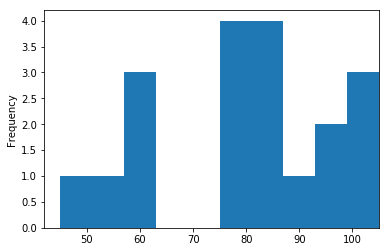

In [5]:
#write_to_csv(df.sort_values('Score', ascending=False),rawdatafilename)
if (os.path.isfile('mystyle.css')):
    write_to_webpage(df, item_analysis_df, point_drop, number_correct_by_version, students_by_version, list_of_free_qs=freebies)
else:
    print("Copy the css file over first")

In [ ]:
###################### DEV AREA###########################################


In [ ]:
just_answers_df=df.loc[:,"Answers"]
just_answers_df=just_answers_df.apply(str)
just_answers_df=just_answers_df.apply(lambda x: x.replace(' ', 'b'))
just_answers_df=just_answers_df.apply(lambda x: ' '.join(list(x)))
just_answers_df=just_answers_df.str.split(' ', expand=True)

n = 2
#just_answers_df.sort_values(list(just_answers_df)[-1])
part_df = just_answers_df.loc[just_answers_df[list(just_answers_df)[-1]] == str(n)]
if not part_df.empty:
    print("Analysing data for version: "+chr(n+65))
    part_df = part_df.T
    part_df = part_df.apply(pd.Series.value_counts, axis = 1).fillna(0)
    if 'b' in list(part_df):
        part_df.rename(columns = {'b': 'Blank'}, inplace = True)
    vers = list(part_df)
    if 'Blank' in vers: 
        vers.remove('Blank')
    lvers = [chr(int(x)+65) for x in vers]
    part_df.rename(columns = dict(zip(vers,lvers)), inplace=True)
    num_students_this_version = part_df.iloc[0,:].sum()
    part_df = make_into_percent(part_df)
    part_df = part_df.applymap('{:,.0f}%'.format)
    if not 'Blank' in list(part_df):
        part_df['Blank']=''
    question_list = list(koschen_paper[n].loc[:,"Question"])
    part_df.index = question_list
    kp = koschen_paper[n].copy()
    kp.set_index("Question", inplace = True)
    kp.index.name = None ###This prevents an extra fictitious row from showing up in the header row

    part_df = kp+"<"+part_df+">"
    part_df = part_df.applymap(lambda m: re.sub('<0%>', '', m) )
    part_df = part_df.applymap(lambda m: re.sub('<>', '', m) )
    part_df = mark_correct_answers(part_df,n,keylist)

In [ ]:
part_df

In [ ]:
kp

In [ ]:
part_df

In [ ]:
def analyse_items(df, koschen_paper, keylist):
    '''create separate dfs with how many marked correct for each version separately'''

    outvars=[]
    versionsfound=[]
    students_in_this_version=[]
    
    just_answers_df=df.loc[:,"Answers"]
    just_answers_df=just_answers_df.apply(str)
    just_answers_df=just_answers_df.apply(lambda x: x.replace(' ', 'b'))
    just_answers_df=just_answers_df.apply(lambda x: ' '.join(list(x)))
    just_answers_df=just_answers_df.str.split(' ', expand=True)

    for n in range(0,len(koschen_paper)):
        ##get answers for version n
        part_df = just_answers_df.loc[just_answers_df[list(just_answers_df)[-1]] == str(n)]
        if not part_df.empty:
            print("Analysing data for version: "+chr(n+65))
            part_df = part_df.T
            part_df = part_df.apply(pd.Series.value_counts, axis = 1).fillna(0)
            if 'b' in list(part_df):
                part_df.rename(columns = {'b': 'Blank'}, inplace = True)
            vers = list(part_df)[:-1]
            lvers = [chr(int(x)+65) for x in vers]
            part_df.rename(columns = dict(zip(vers,lvers)), inplace=True)
            num_students_this_version = int(part_df.iloc[0,:].sum())
            part_df = make_into_percent(part_df)
            part_df = part_df.applymap('{:,.0f}%'.format)
            question_list = list(koschen_paper[n].loc[:,"Question"])
            part_df.index = question_list
            kp = koschen_paper[n].copy()
            kp.set_index("Question", inplace = True)
            kp.index.name = None ###This prevents an extra fictitious row from showing up in the header row
            part_df = kp+"<"+part_df+">"
            part_df = part_df.applymap(lambda m: re.sub('<0%>', '', m) )
            part_df = mark_correct_answers(part_df,n,keylist)
            
            outvars.append(part_df)
            versionsfound.append(lvers[n])
            students_in_this_version.append(num_students_this_version)
    
    
#     Return two dict so that the html function knows which version each table belongs to, and how many students took that version    
    return dict(zip(versionsfound,outvars)), dict(zip(versionsfound,students_in_this_version))


In [ ]:
number_correct_by_version, students_by_version = analyse_items(df, koschen_paper,keylist)

In [ ]:
students_by_version['D']

In [ ]:
whichkey=2

In [ ]:
exempt_list[]

In [ ]:
3 not in exempt_list[whichkey]

In [ ]:
QIDs

In [ ]:
m=koschen_paper[0].loc[1,"Question"]
print(m)

In [ ]:
uu=list(koschen_paper[1].loc[:,"Question"])
uu.index(process.extractOne(m,uu)[0])

In [ ]:
uu[13]

In [ ]:
v0=list(koschen_paper[0].loc[:,"Question"])
v1=list(koschen_paper[1].loc[:,"Question"])
v2=list(koschen_paper[2].loc[:,"Question"])
v3=list(koschen_paper[3].loc[:,"Question"])

In [ ]:
item_analysis_df = make_item_analysis(analysis_df, v0_question_list) 

In [ ]:
item_analysis_df

In [ ]:
analysis_df

In [ ]:
All_IDs[1]

In [ ]:
qids_new=[]
qid_list=[x for x in range(0, 15)]
qids_new.append(qid_list)

for whichlist in All_IDs[1:]:
    qid_list=[1]*len(All_IDs[0])
    for m in range(0,len(All_IDs[0])):
        matching_question=process.extractOne(All_IDs[0][m], whichlist)[0]
        qid_list[whichlist.index(matching_question)]=m
    qids_new.append(qid_list)

In [ ]:
analysis_df

In [ ]:
All_IDs[0][0]

In [ ]:
m=0
len(All_IDs[0])

In [ ]:
whichlist=All_IDs[1]
matching_question=process.extractOne(All_IDs[0][m], whichlist)[0]

In [ ]:
matching_question

In [ ]:
whichlist.index(matching_question)

In [ ]:
qid_list[whichlist.index(matching_question)]=m

In [ ]:
list(QIDs[0])+["score"]

In [ ]:
!pip install fuzzywuzzy

In [ ]:
!python3.6 -m pip install fuzzywuzzy

In [ ]:
assert(keylist and pointlist and QIDs and koschen_paper and numberOfQuestions!=0),"Either keylist or pointlist or QIDs or koschen_paper or  numberOfQuestions is null"

In [ ]:
ord('A')

In [ ]:
v=1
chr(65+v)

In [ ]:
koschen_paper[0]